# Multipoint ICMEs September/October 2021

---

**MIT LICENSE**

Copyright 2021, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import seaborn as sns
import numpy as np
import scipy.io
from scipy import stats
import sys
from datetime import timedelta
import time
import pickle
import os
import copy
import urllib
import json
import warnings
import importlib

import heliocats.data as hd

import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

import astropy
import astropy.constants as const

#our own packages
import py3dcore
import heliosat

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_sig.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

plt.rcParams["figure.figsize"] = (15,8)
plt.close('all')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3


print('sunpy:',sunpy.__version__)
print('astropy:',astropy.__version__)

print('done')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
sunpy: 1.1.0
astropy: 4.0
done


In [6]:
print('load data RTN') 

#filepsp='psp_2018_2021_rtn.p'
#[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 

filenoaa="noaa_rtsw_last100days_now.p" 
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) )  
    
filewin="wind_2018_now_heeq.p" 
[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

filesta='stereoa_2020_now_rtn_beacon.p'
[sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

filebepi='bepi_2021_ib_rtn.p'
bepi=pickle.load(open(data_path+filebepi, "rb" ) ) 

filesolo='solo_2021_lowlat.p'
solo=pickle.load(open(data_path+filesolo, "rb" ) ) 

print('done')
    


load data RTN
done


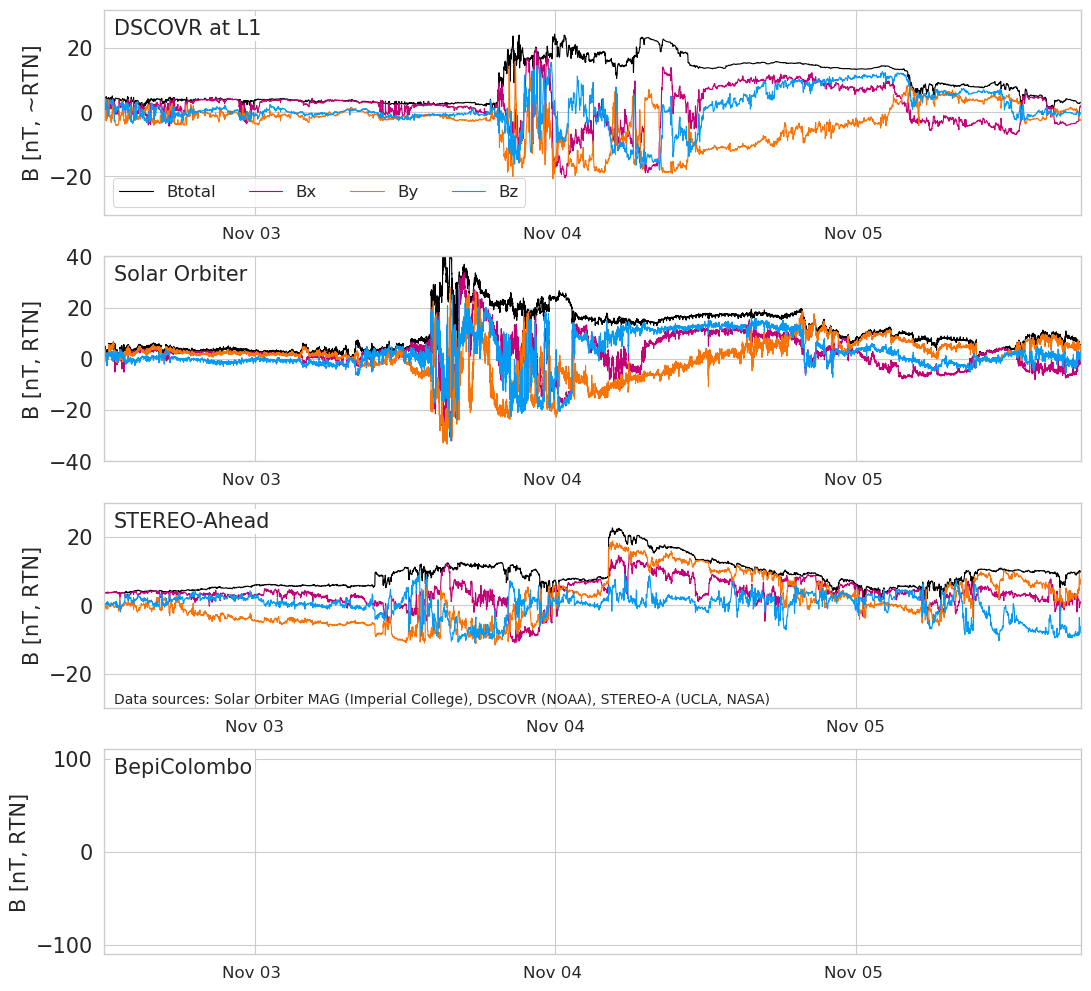

In [19]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(11, 10),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 1), (0, 0))  
ax2 = plt.subplot2grid((4, 1), (2, 0))  
ax3 = plt.subplot2grid((4, 1), (1, 0))  
ax4 = plt.subplot2grid((4, 1), (3, 0))  



#plotstart=datetime.datetime(2021,10,11)
#plotend=datetime.datetime(2021,10,13,6)

plotstart=datetime.datetime(2021,11,2,12)
plotend=datetime.datetime(2021,11,5,18)



blim=32

linewi=0.8

days_dist=1


#DSCOVR
ax1.plot(noaa.time, noaa.bt, "k-", lw=linewi,label='Btotal')
ax1.plot(noaa.time, -noaa.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax1.plot(noaa.time, -noaa.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax1.plot(noaa.time, noaa.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')

ax1.set_ylabel('B [nT, ~RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=3,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
ax1.tick_params(axis='x', labelsize=12)

### STEREO-A
blim=30

ax2.plot(sta.time, sta.bt, "k-", lw=linewi,label='Btotal')
ax2.plot(sta.time, sta.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
ax2.plot(sta.time, sta.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
ax2.plot(sta.time, sta.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Solar Orbiter
blim=40
ax3.plot(solo.time, solo.bt, "k-", lw=linewi,label='Btotal')
ax3.plot(solo.time, solo.bx, "r-", color="xkcd:magenta", lw=linewi, label='Bx')
ax3.plot(solo.time, solo.by, "g-", color="xkcd:orange", lw=linewi,label='By')
ax3.plot(solo.time, solo.bz, "b-", color="xkcd:azure", lw=linewi,label='Bz')
    
ax3.set_ylabel('B [nT, RTN]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


### Bepi
blim=110

ax4.plot(bepi.time, bepi.bt, "k-", lw=linewi,label='Btotal')
ax4.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=linewi, label='Br')
ax4.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=linewi,label='Bt')
ax4.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=linewi,label='Bn')


    
ax4.set_ylabel('B [nT, RTN]',fontsize=15)
ax4.set_xlim(plotstart,plotend)
ax4.set_ylim(-blim,blim)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', labelsize=15)
ax4.grid(True)
ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d ') )
ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))


ax1.annotate('DSCOVR at L1',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax2.annotate('STEREO-Ahead',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax3.annotate('Solar Orbiter',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))
ax4.annotate('BepiColombo',(0.01,0.88),xycoords='axes fraction',fontsize=15,bbox=dict(facecolor='white', edgecolor='None', pad=2.0))

ax2.annotate('Data sources: Solar Orbiter MAG (Imperial College), DSCOVR (NOAA), STEREO-A (UCLA, NASA)',(0.01,0.02),xycoords='axes fraction',fontsize=10)
#ax4.annotate('Data sources: BepiColombo MPO-MAG (IGEP Braunschweig/IWF Graz/ISAS/IC), Solar Orbiter MAG (Imperial C.), DSCOVR (NOAA), STEREO-A (UCLA, NASA)',(0.01,0.02),xycoords='axes fraction',fontsize=10)


plt.tight_layout()


plt.savefig('lineups/erc/figure_2021_nov2_cme.png')
plt.savefig('lineups/erc/figure_2021_nov2_cme.pdf')
#plt.savefig('lineups/fall_2021/figure_2021_fall_lineups_beg_oct1.pdf')
#plt.savefig('lineups/figure_2020_sep_lineups.pdf')

#ax2.plot(bepi.time, bepi.bt, "k-", lw=1,label='Btotal')
#ax2.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
#ax2.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax2.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=1,label='Bn')

#ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
#ax3.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
#ax3.plot(win.time, win.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bn')


In [5]:
#CACTUS
url_cactus='https://wwwbis.sidc.be/cactus/catalog/LASCO/2_5_0/cmecat_combo.sav'

try: urllib.request.urlretrieve(url_cactus,'data/LASCO_CME/cmecat_combo.sav')
except urllib.error.URLError as e:
    print('lasco cme not loaded')


#LASCO CME catalog 
url_lasco='https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'

try: urllib.request.urlretrieve(url_lasco,'data/LASCO_CME/univ_all.txt')
except urllib.error.URLError as e:
    print('lasco cme not loaded')

In [6]:
#read lasco catalog

la=np.genfromtxt('data/LASCO_CME/univ_all.txt',dtype=(str), usecols=[0,1,2,3,4,5,6,7,8,9,10,11],skip_header=4)

la_time=[]
cpa=np.zeros(len(la))
width=np.zeros(len(la))
speedlin=np.zeros(len(la))

# ========= SOHO/LASCO CME CATALOG==========      LAST UPDATED: 2021/08/09 13:39
# Date       Time     Central  Width  Linear   2nd order speed      Accel     Mass      Kinetic    MPA   Remarks
#                        PA           Speed  initial final   20R                        Energy                 

for i in np.arange(0,len(la)):
    #convert time from string to datetime
    la_time.append(parse_time(la[i][0]+' '+la[i][1]).isot)
    
    
    if la[i][2]=='Halo': 
        cpa[i]=360
    else:
        cpa[i]=float(la[i][2])

    width[i]=int(la[i][3])
    
    if la[i][4]=='----':
        speedlin[i]=np.nan
    else:
        speedlin[i]=int(la[i][4])

#print(la_time)
#print(cpa)
#print(width)
#print(speedlin)

data=np.vstack([parse_time(la_time).datetime,cpa,width,speedlin])
# Create the pandas DataFrame
ldf = pd.DataFrame(data.transpose(), columns = ['time','cpa','width','speed'])
                                   

### load WSA/THUX solar wind speed data

In [7]:
wsa_all=np.loadtxt('data/thux/wsa-planets-missions-cr2047-cr2246.txt',skiprows=1)

#file looks like
#Time[matlab]	vEarth	vMercury	vVenus	vMars	vBepi	vPSP	vSOLO	vSTEREOA	vSTEREOB			

#need to convert matlab time to matplotlib time
wsa_all_datetime=[None]*len(wsa_all)
for p in np.arange(len(wsa_all)):
        wsa_all_datetime[p]= datetime.datetime.fromordinal(wsa_all[p,0].astype(int) ) + \
        datetime.timedelta(days=wsa_all[p,0]%1) - datetime.timedelta(days = 366) 


#make recarray
thux=np.zeros(np.size(wsa_all_datetime),dtype=[('time',object),('wind', float),('bepi', float),\
            ('psp', float),('solo', float),('sta', float)] )   

#convert to recarray
thux = thux.view(np.recarray)  
thux.time=wsa_all_datetime
thux.wind=wsa_all[:,1]
thux.bepi=wsa_all[:,5]
thux.psp=wsa_all[:,6]
thux.solo=wsa_all[:,7]
thux.sta=wsa_all[:,8]                                       

print('done')

done
